In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import pandas as pd


import tensorflow as tf
import tf_data

In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


In [6]:
!nvidia-smi

Thu Jun  3 12:43:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:07.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    258MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Dataset building

In [5]:
# check max number of samples
df_ele_train = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/records_metadata.txt", sep=';')
df_ele_test = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/testing/records_metadata.txt", sep=';')
df_gamma_train = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/records_metadata.txt", sep=';')
df_gamma_test = pd.read_csv("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/testing/records_metadata.txt", sep=';')

In [6]:
print( "Ele training: ", df_ele_train[df_ele_train["class"]!=0].n.sum())
print( "Gamma training: ", df_gamma_train[df_gamma_train["class"]!=0].n.sum())
print( "Ele test: ", df_ele_test[df_ele_test["class"]!=0].n.sum())
print( "Gamma test: ", df_gamma_test[df_gamma_test["class"]!=0].n.sum())

print("unmatched training: ",df_ele_train[df_ele_train["class"]==0].n.sum() + df_gamma_train[df_gamma_train["class"]==0].n.sum()  )
print("unmatched testing: ", df_ele_test[df_ele_test["class"]==0].n.sum() + df_gamma_test[df_gamma_test["class"]!=0].n.sum()  )

Ele training:  1434462
Gamma training:  2876024
Ele test:  475617
Gamma test:  478838
unmatched training:  8803679
unmatched testing:  1450785


In [7]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [8]:
features = [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

window_features = [  "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ]

# Metadata about the window like true energy, true calo position, useful info
window_metadata = ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU","wtot_recoen_PU","wtot_simen_sig" ]
    
    

In [9]:
_load_n_items = 10
_batch_size = 6
_nepochs = 1
_ntrain = 10000
_nval = 1000

In [16]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features,window_features, window_metadata,  _batch_size)
# the indexes for energy and et are from the features list we requestes
# total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds, norm=False) 

In [17]:
X,y = tf_data.get(total_ds)

In [28]:
in_sc, w_flavour, wind_meta = y

In [20]:
cl_X,cl_hits, wind_X, is_seed,n_cl = X

# Graph building layer

In [67]:
from model import *
from plotting import * 

In [68]:
graph = GraphBuilding(output_dim_nodes=32)

In [54]:
rcn = RechitsGCN(nconv=3, input_dim = 4 , output_dim =12)

In [55]:
rechits = cl_hits.to_tensor()
mask_rechits, mask_cls = create_padding_masks(rechits)

In [56]:
output, (sa_output,convout, attention_weights, adj) = rcn(rechits, mask_rechits)

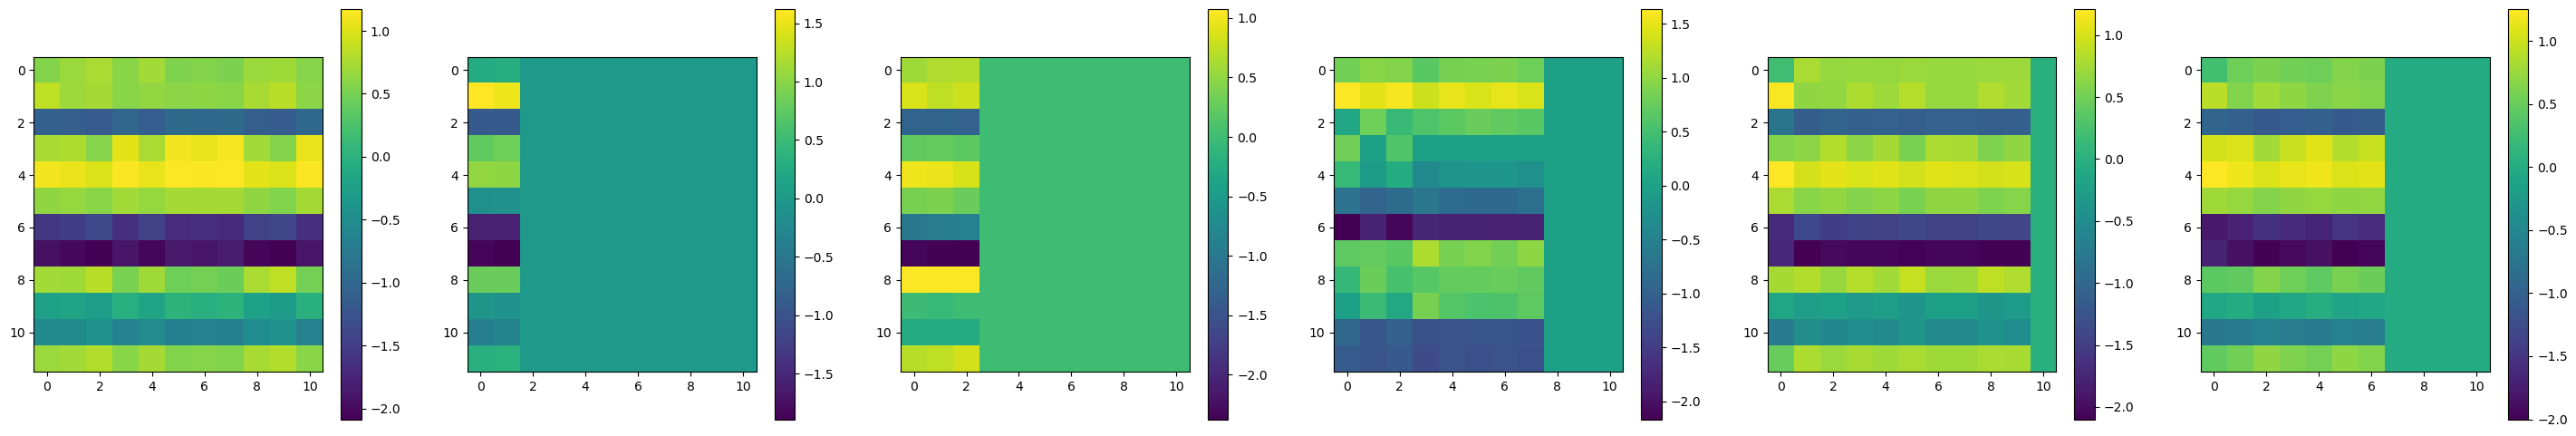

In [58]:
plotM(*output)

In [70]:
cl_x, coord, adj, mask, output_rechits, coord_att_ws = graph(X[0],X[1])

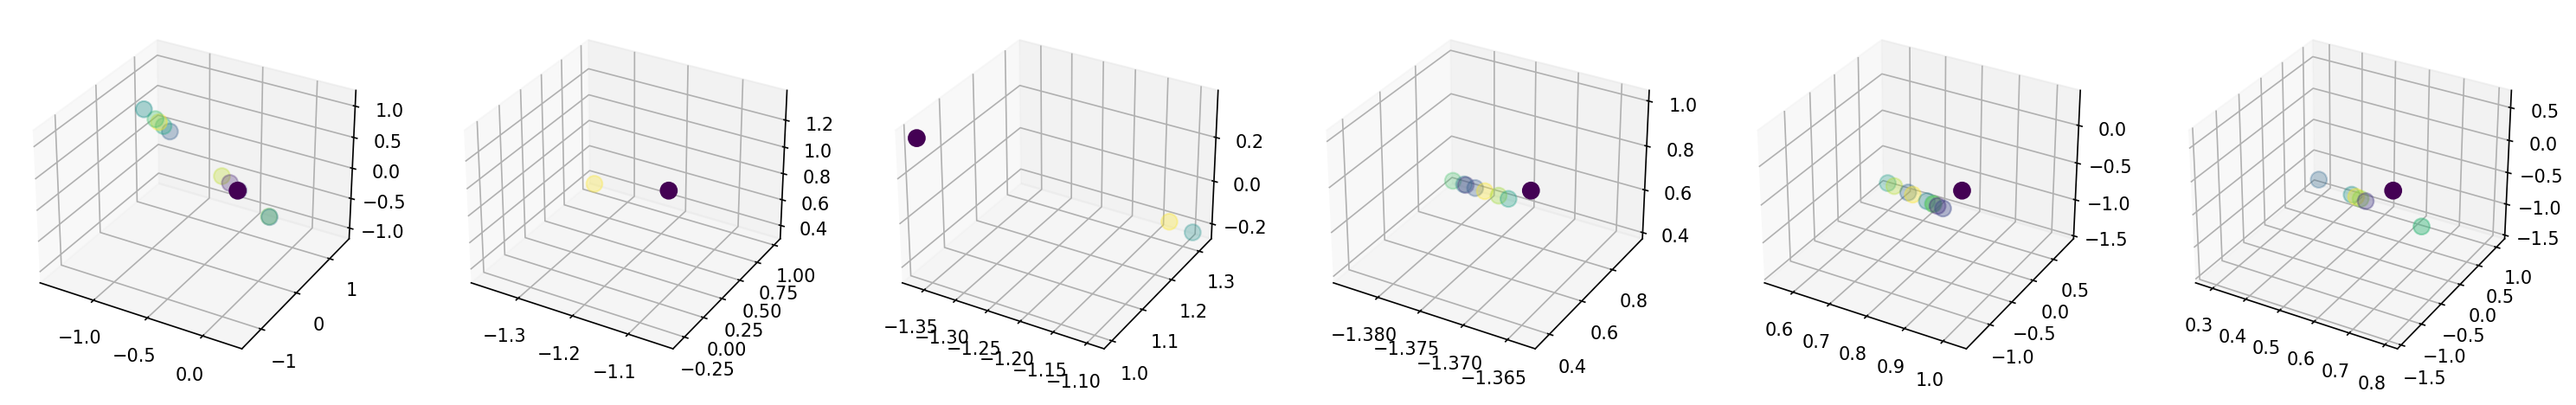

In [71]:
plot3D(coord, mask)

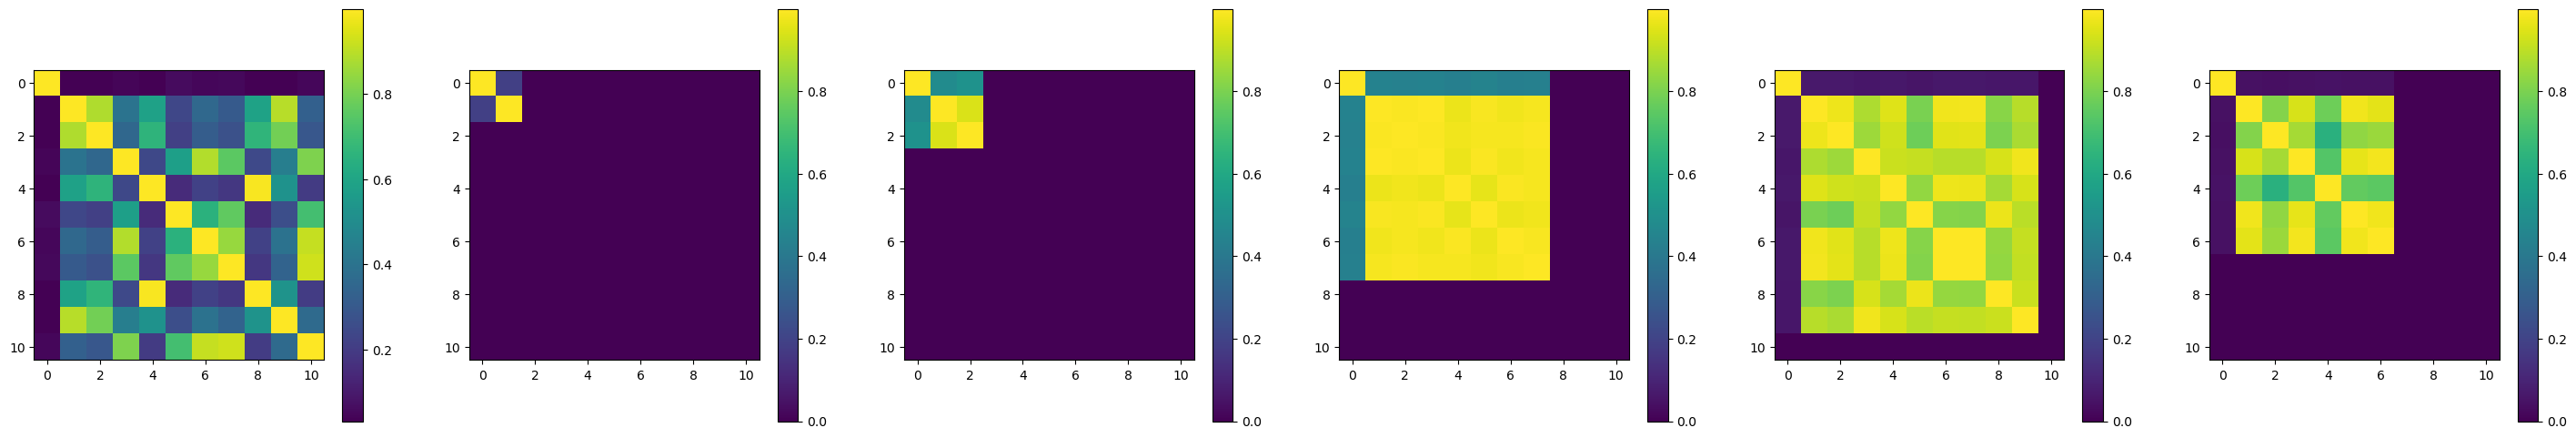

In [72]:
plotM(*adj)

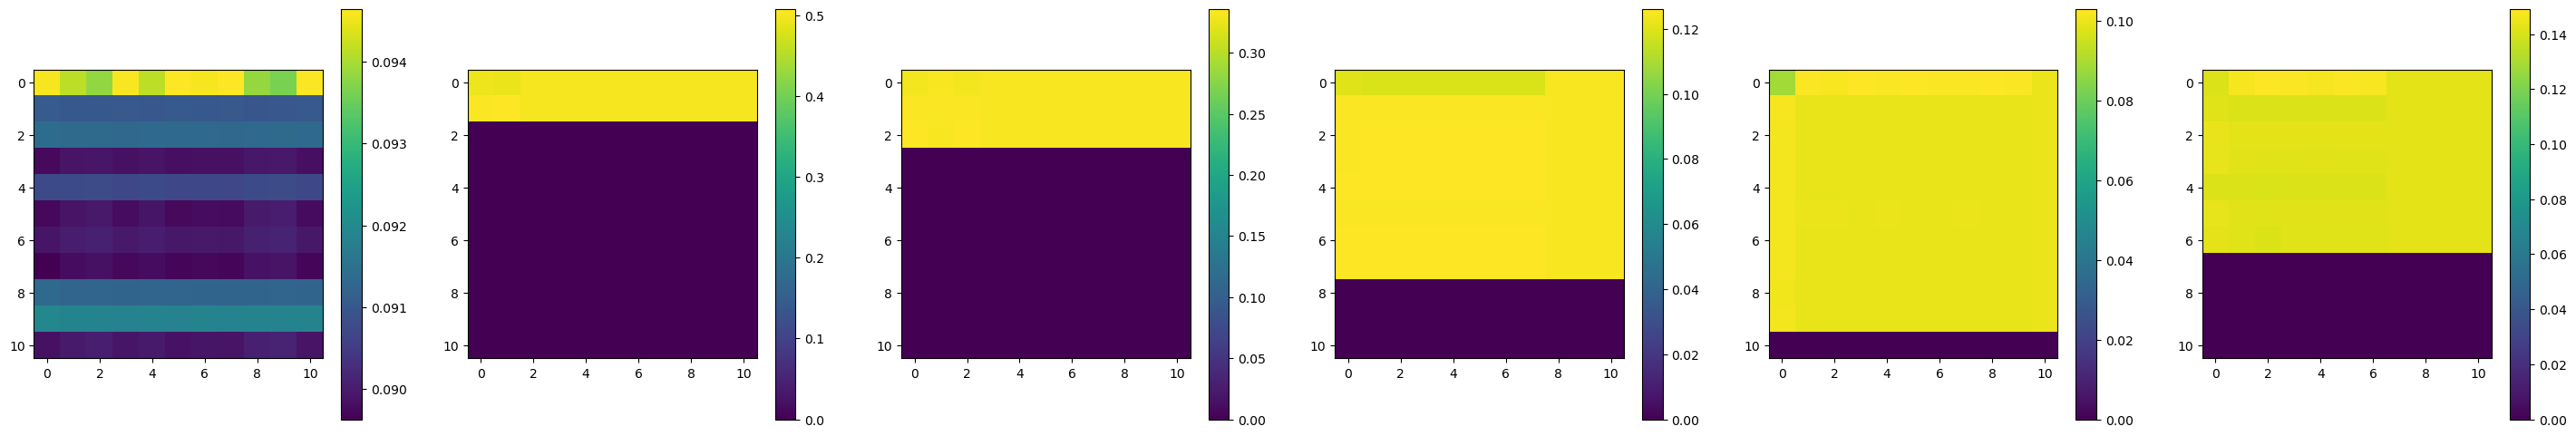

In [75]:
plotM(*coord_att_ws)

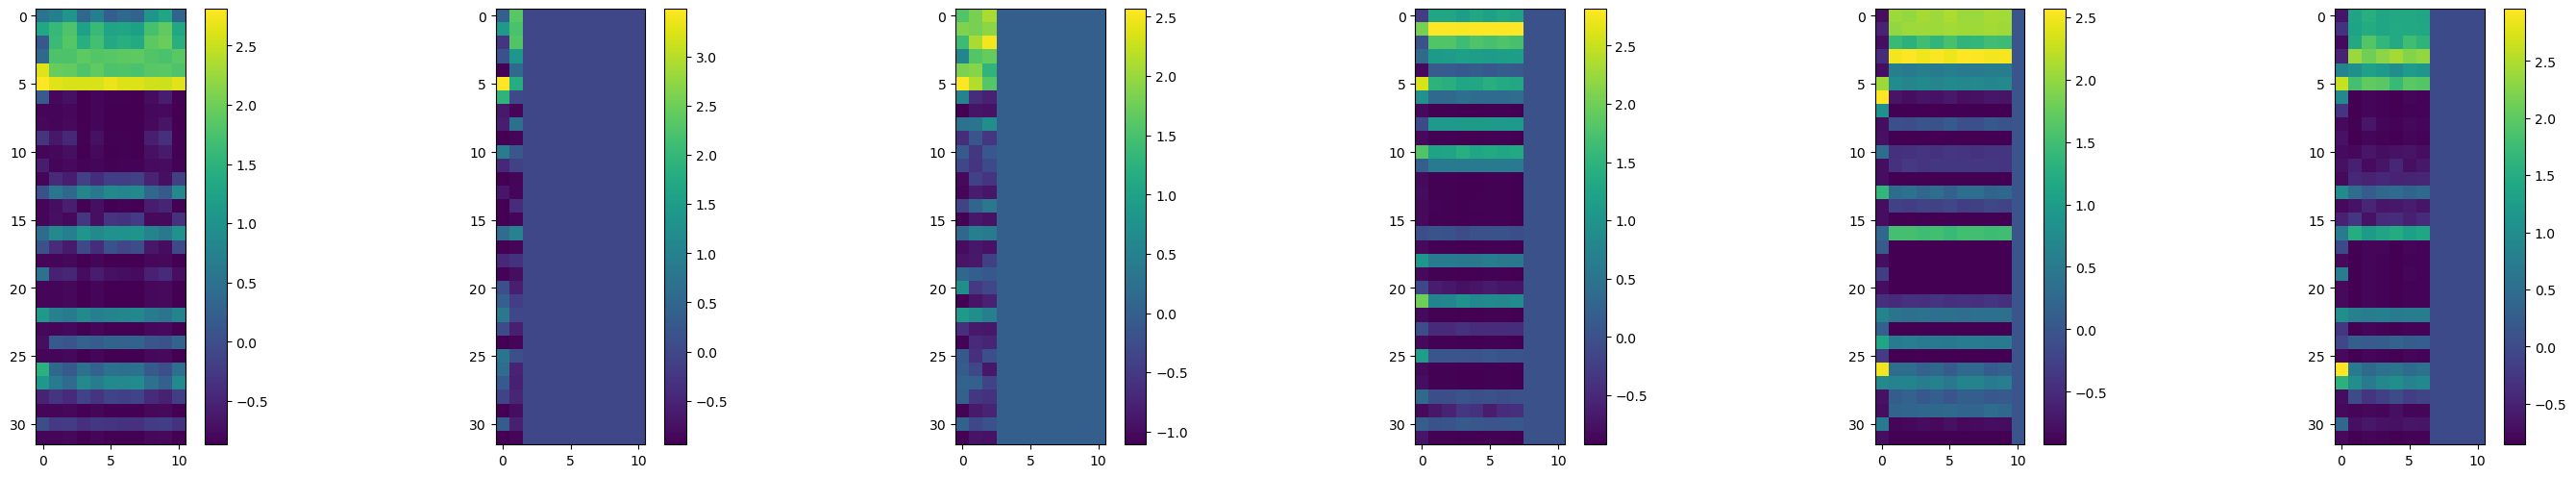

In [93]:
plotM(*cl_x)

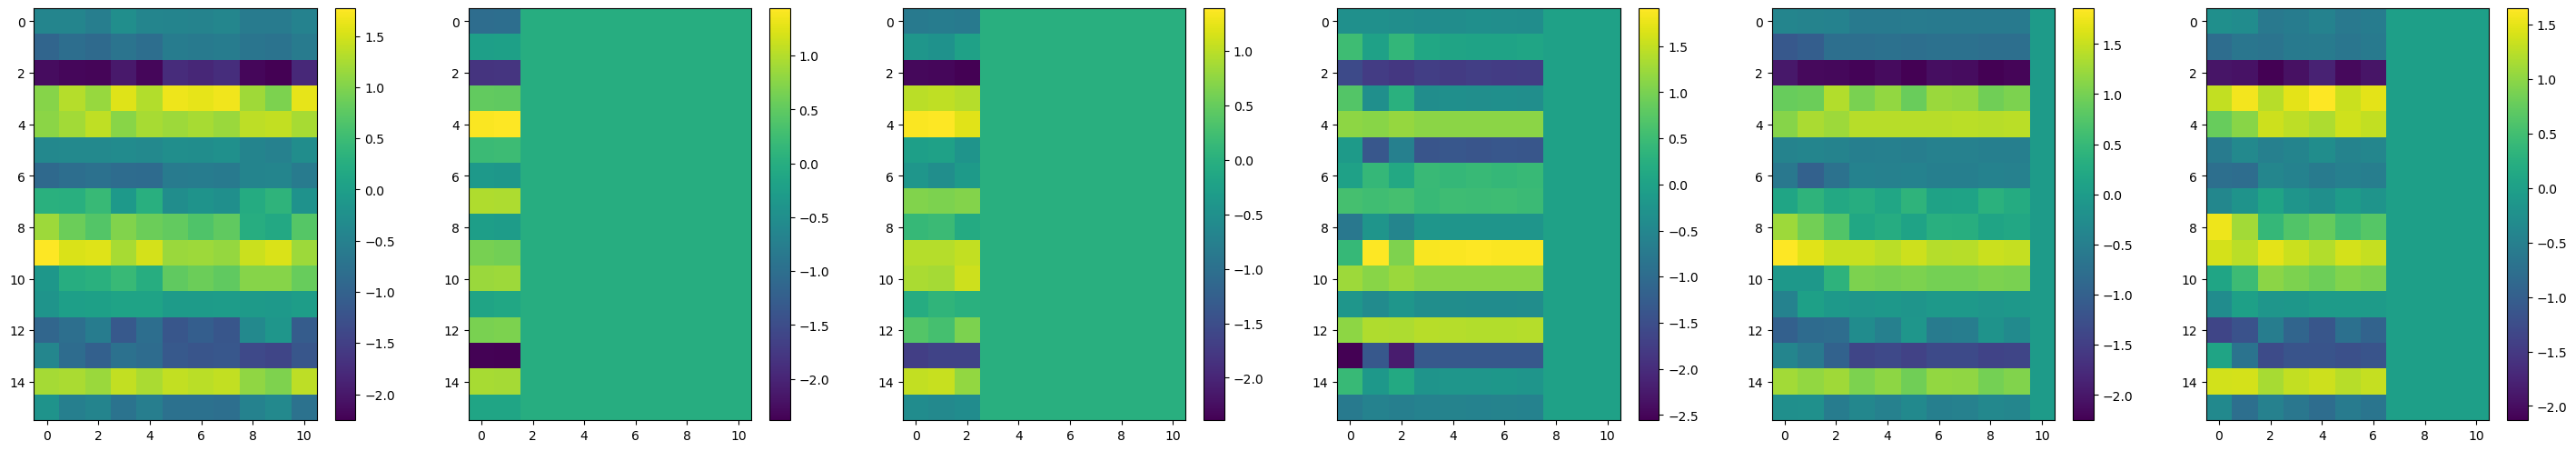

In [74]:
plotM(*output_rechits)

# Complete model

In [80]:
from model import *
from plotting import * 

In [81]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=32, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [27]:
a = model(X)

In [58]:
X, y = tf_data.get(ds_train)

In [22]:
X,y = tf_data.get(ds_test)

In [40]:
X,y = tf_data.get(special_ds)

In [42]:
(dense_clclass, windclass, enregr), mask_cls, \
    (cl_X, coord, adj, coord_att_ws, output_rechits, out_gcn, out_SAcl ,out_SAw, att_weights_clcall, att_w_windclass,att_weights_en) = model(X)

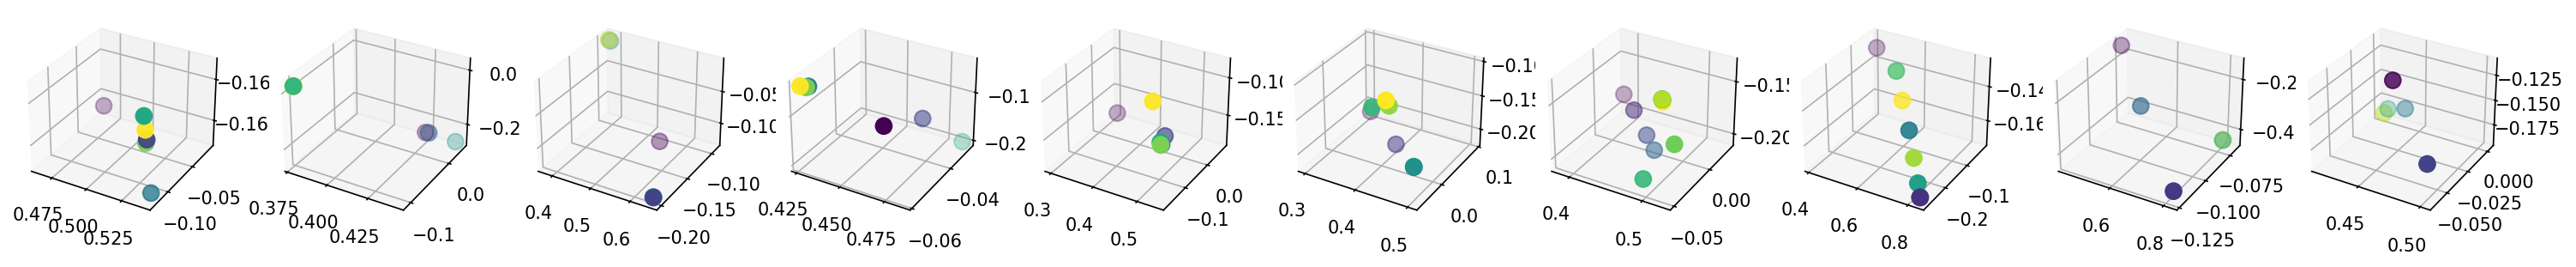

In [43]:
plot3D(coord[0:10], mask_cls)

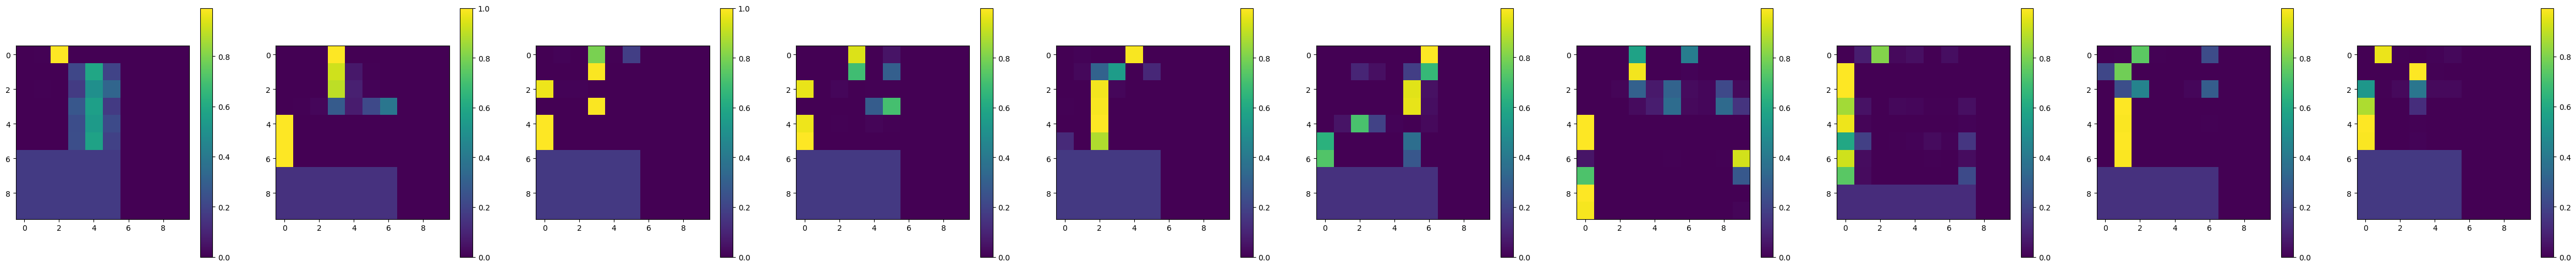

In [44]:
plotM(*coord_att_ws[0:10], t=False)

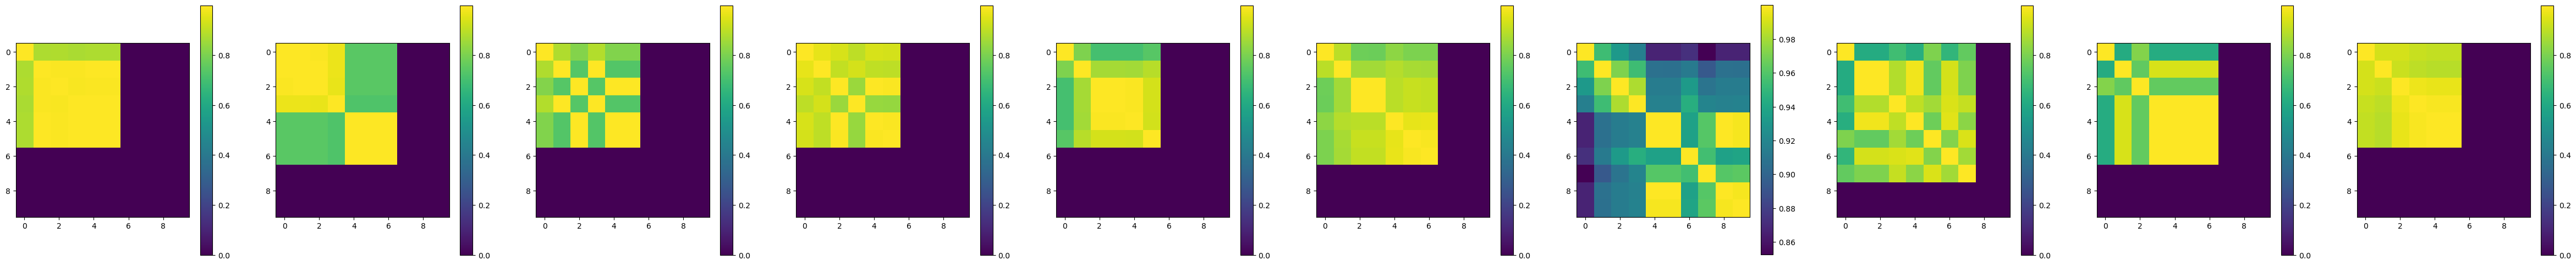

In [45]:
plotM(*adj[0:10])

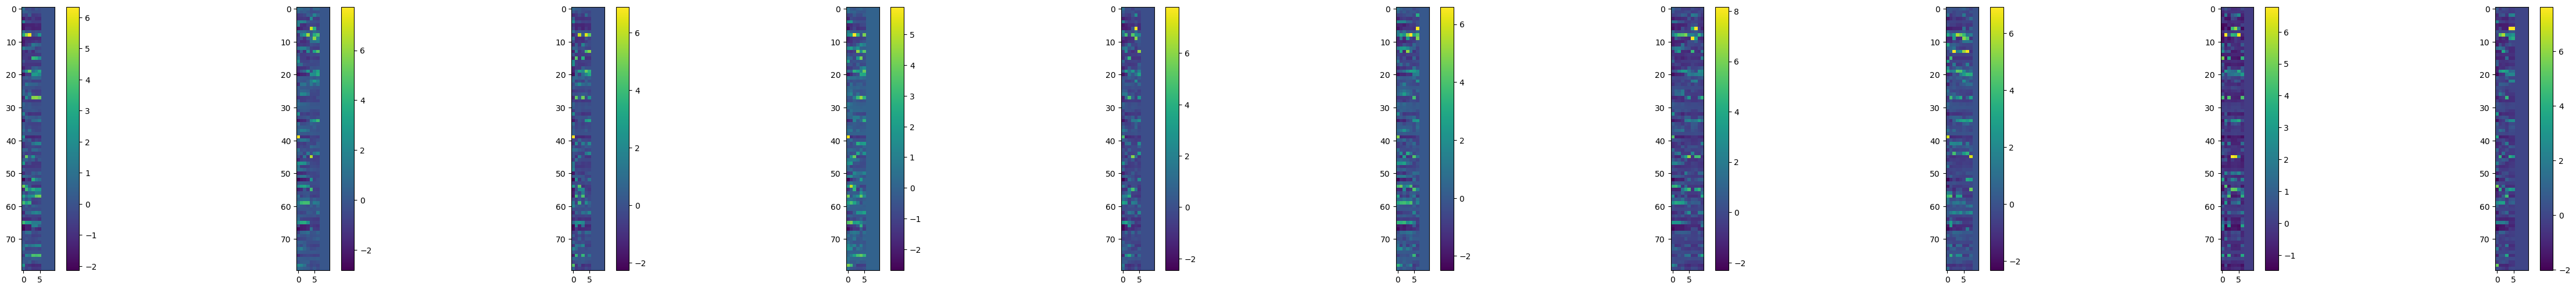

In [46]:
plotM(*cl_X[0:10])

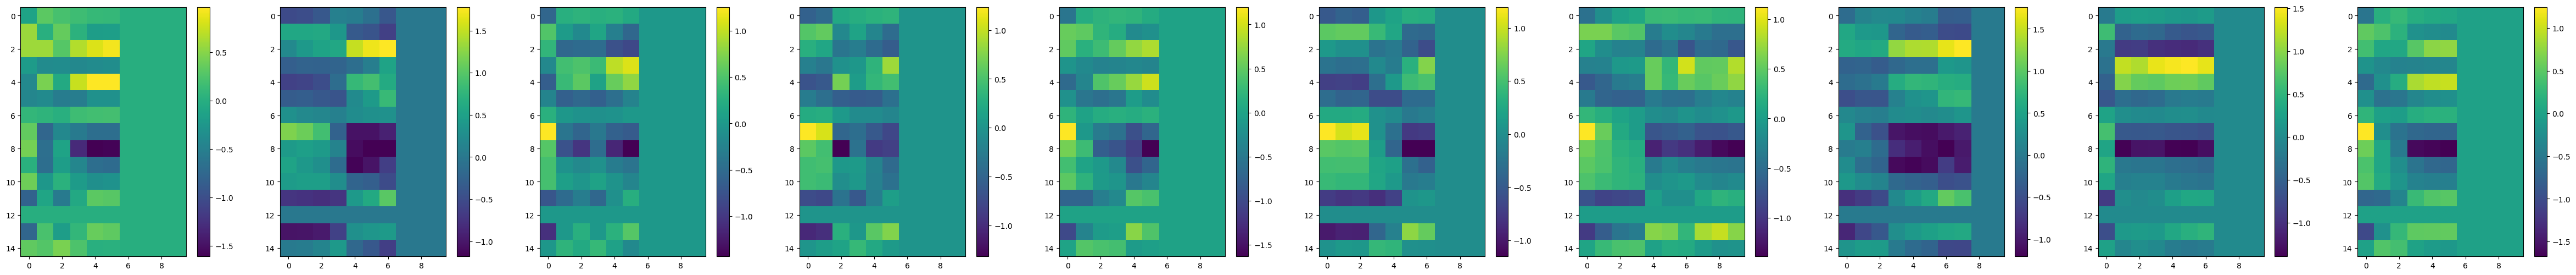

In [47]:
plotM(*output_rechits[0:10])

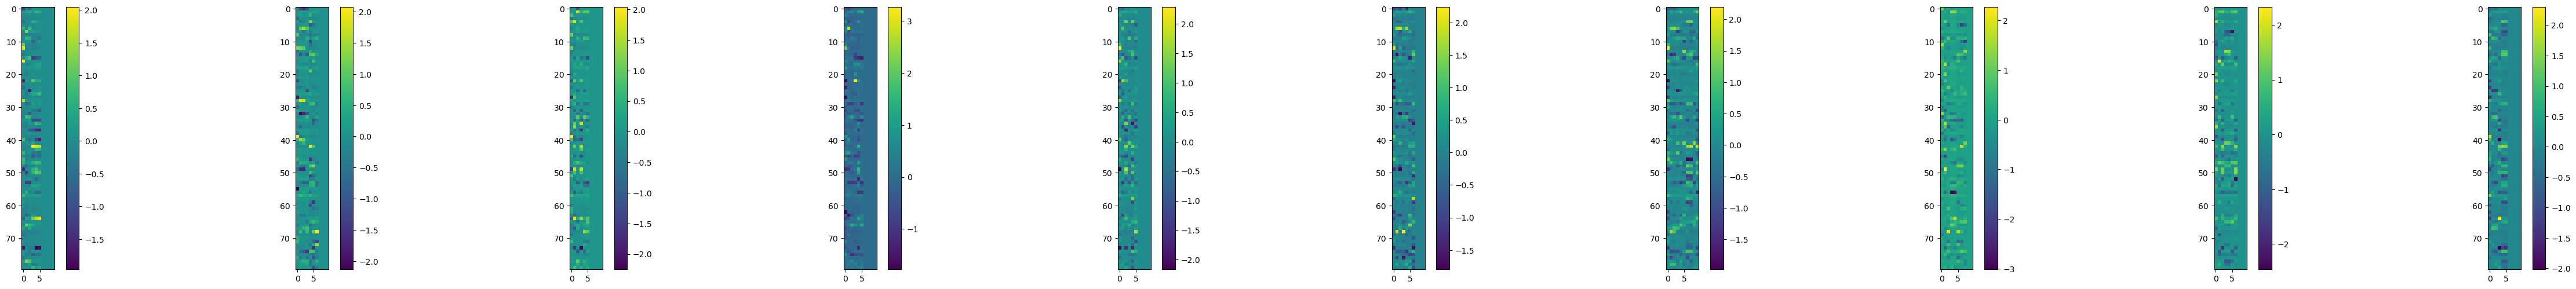

In [48]:
plotM(*out_gcn[0:10])

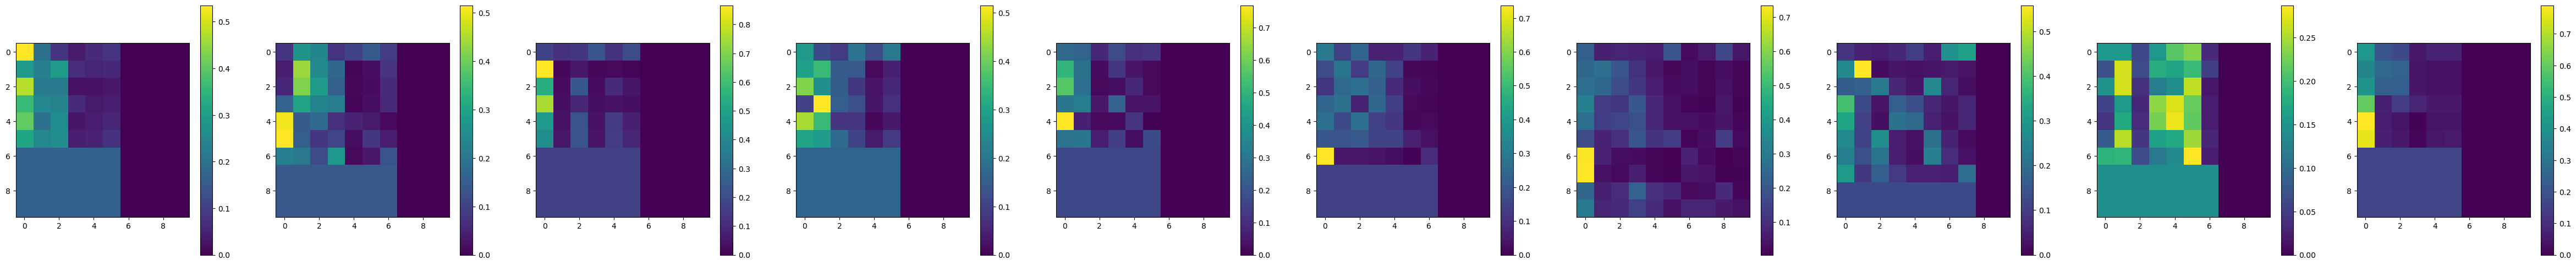

In [49]:
plotM(*att_weights_clcall[0:10], t=False)

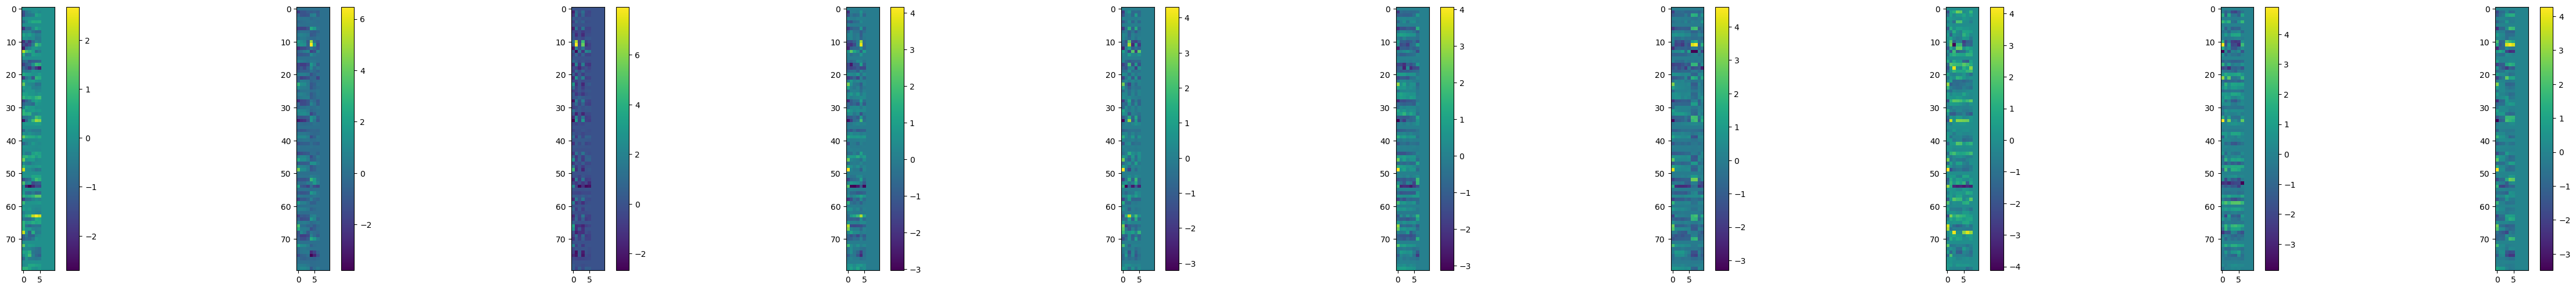

In [50]:
plotM(*out_SAcl[0:10])

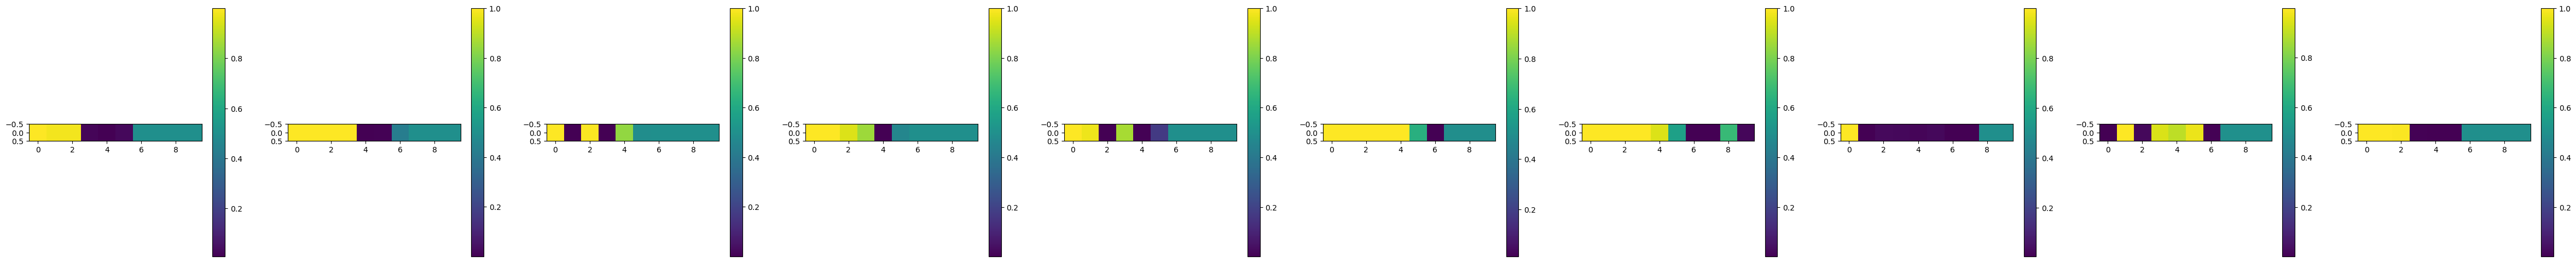

In [51]:
plotM(*tf.nn.sigmoid(dense_clclass)[0:10])

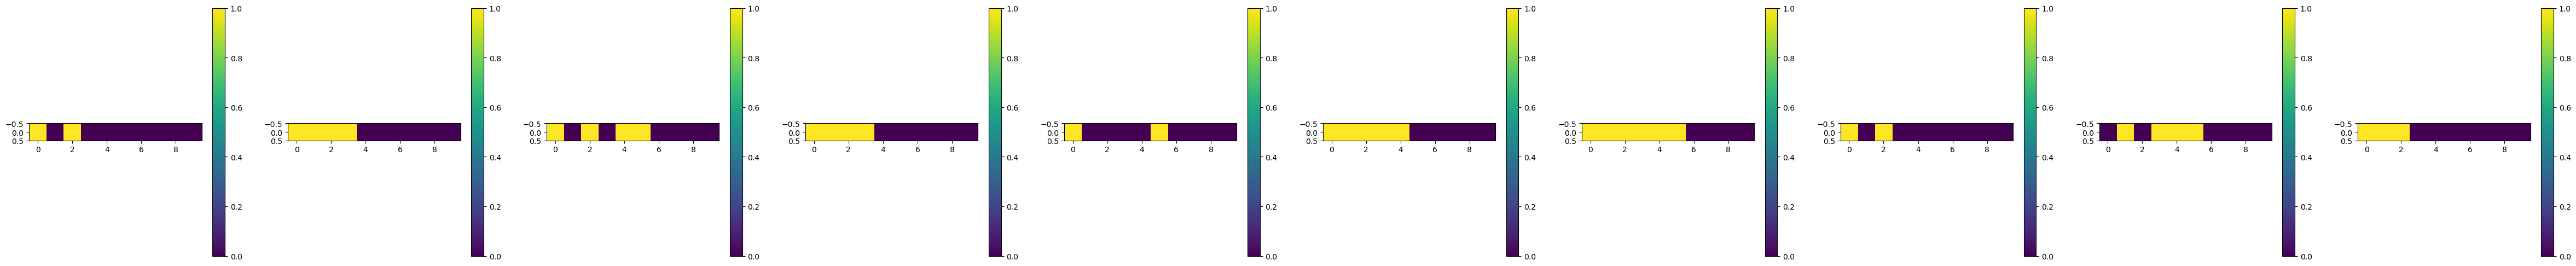

In [52]:
plotM(*y[0][0:10])

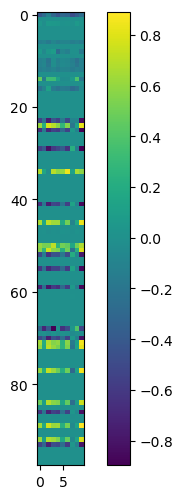

In [53]:
plotM(out_SAw[0:10])

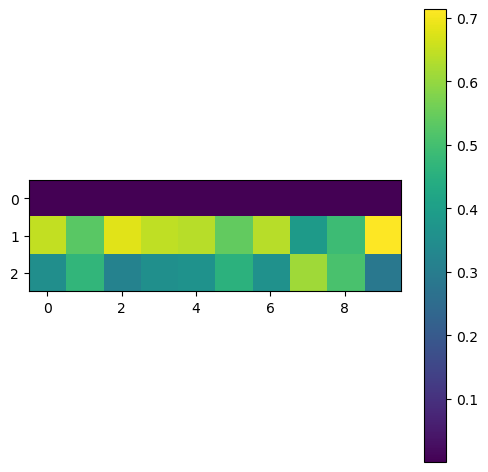

In [54]:
plotM(tf.nn.softmax(windclass[0:10]))

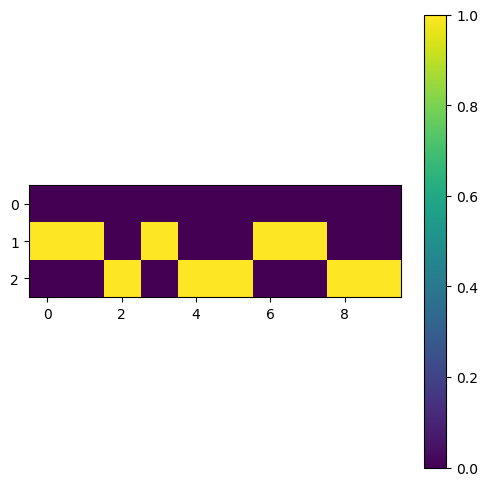

In [55]:
plotM(y[1][0:10])

# Test training

In [7]:
from model import *
from plotting import * 

- Ele training:  199254
- Gamma training:  299529
- Ele test:  38275
- Gamma test:  26130
- unmatched training:  758757
- unmatched testing:  84404

In [9]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_et_miss','loss_et_spur','loss_en_regr'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 0,
nepochs = 100,
ntrain = 1500000,
nval = 250000,
lr_decay = 0.,
lr = 1e-3,
batch_size = 512,
opt='adam',
    
activation = tf.keras.activations.elu,
output_dim_rechits = 15,
output_dim_nodes = 80,
output_dim_gconv = 80,
output_dim_sa_clclass = 80,
output_dim_sa_windclass = 80,
output_dim_sa_enregr = 80,
coord_dim = 3,
coord_dim_sa = 15,
nconv_rechits = 4,
nconv = 4,
layers_input = [128,128,80,80],
layers_clclass = [64,32,32,32],
layers_windclass = [64,64,32],
layers_enregr = [64,32],
n_windclasses = 3, 
dropout = 0.1,
l2_reg = True, 
    
loss_clusters= 3.,
loss_window= 1.4, 
loss_softF1= 0.2,
loss_et_miss= 7., 
loss_et_spur= 7.,
loss_en_regr = 0.000
)

### Dataset loading

In [10]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01


In [11]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v9/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v9/training/calo_matched/*.proto",
                  "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v9/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v9/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v9/testing/calo_matched/*.proto",
                   "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v9/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [12]:
features_dict = {

"cl_features" : [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"],

 "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                    "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                    "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

# Metadata about the window like true energy, true calo position, useful info
 "window_metadata" :  ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig"  ]    
}
    
    

In [13]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features_dict, args.batch_size,weights={"ele_match":0.375,"gamma_match":0.375, "nomatch":0.25} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.normalize_features(train_ds, "normalization_v9.npz", "normalization_wind_features_v9.npz")
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test,features_dict, args.batch_size,weights={"ele_match":0.375,"gamma_match":0.375, "nomatch":0.25})
# the indexes for energy and et are from the features list we requestes
# test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.normalize_features(test_ds, "normalization_v9.npz", "normalization_wind_features_v9.npz")
test_ds = tf_data.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(300).take(args.ntrain // args.batch_size).repeat(args.nepochs)
ds_test  = test_ds.prefetch(300).take(args.nval // args.batch_size).repeat(args.nepochs)

In [39]:
def filter(d1,d2):
    return  d1["s_f"][0] > 1.4 and  d1["s_f"][0] < 1.8 and d1["n_cl"] > 5 #and d1["s_f"][0] > 1.5 and d1["s_f"][0] < 2.2 and  d1["s_f"][6] < 50

special_ds = tf_data.load_balanced_dataset_batch(data_path_test, features_dict ,  20,filter=filter, weights={"ele_match":0.45,"gamma_match":0.45, "nomatch":0.1})
# the indexes for energy and et are from the features list we requestes
# special_ds = tf_data.delta_energy_seed(special_ds, en_index=0, et_index=1)
special_ds = tf_data.normalize_features(special_ds, "normalization_v9.npz","normalization_wind_features_v9.npz")
special_ds = tf_data.training_format(special_ds)

In [14]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [15]:
def get_model(args, weights=None):

    loss_weights = {"clusters":args.loss_clusters, "window":args.loss_window, 
                    "softF1":args.loss_softF1, "et_miss":args.loss_et_miss, "et_spur":args.loss_et_spur,"en_regr": args.loss_en_regr}
    tf.keras.backend.clear_session()

    
    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        # Construction of the model
        model = DeepClusterGN(
                    activation = args.activation,
                    output_dim_rechits = args.output_dim_rechits,
                    output_dim_nodes =args.output_dim_nodes,
                    output_dim_gconv = args.output_dim_gconv,
                    output_dim_sa_clclass = args.output_dim_sa_clclass,
                    output_dim_sa_windclass = args.output_dim_sa_windclass,
                    output_dim_sa_enregr = args.output_dim_sa_enregr,
                    coord_dim = args.coord_dim,
                    coord_dim_sa = args.coord_dim_sa,
                    nconv_rechits = args.nconv_rechits,
                    nconv = args.nconv,
                    layers_input = args.layers_input,
                    layers_clclass = args.layers_clclass,
                    layers_windclass = args.layers_windclass,
                    layers_enregr = args.layers_enregr,
                    n_windclasses = args.n_windclasses,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg,
                    loss_weights= loss_weights
                    )


        model.compile(optimizer=args.opt)
    #         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
    #                      energy_resolution_insc_log,energy_resolution_outsc_log,])
        model.set_metrics()

        for X, y in ds_train:
            ypred = model(X)
            #l = custom_loss(y, ypred)
            break
        
        if weights:
            model.load_weights(weights)
        
        return model

In [16]:
model = get_model(args)

In [17]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  49093     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  12880     
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  38880     
_________________________________________________________________
dense_clclass (Sequential)   (512, 17, 1)              14529     
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  64480     
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  12675     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [18]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=4, verbose=1,
    mode='auto', min_delta=0.002, cooldown=0, min_lr=1e-8,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=12, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)



callbacks += [cp_callback, lr_reduce, early]



In [19]:
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 1/100
2929/2929 [==============================] - ETA: 0s - loss: 5.4086 - loss_clusters: 0.6750 - loss_windows: 0.6746 - loss_softF1: 0.7146 - loss_et_miss: 0.1445 - loss_et_spur: 0.0909 - loss_en_regr: 8188.8882
Epoch 00001: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.01-4.170951.hdf5
2929/2929 [==============================] - 470s 160ms/step - loss: 5.4086 - loss_clusters: 0.6750 - loss_windows: 0.6746 - loss_softF1: 0.7146 - loss_et_miss: 0.1445 - loss_et_spur: 0.0909 - loss_en_regr: 8188.8882 - val_loss: 4.1710 - val_loss_clusters: 0.4941 - val_loss_windows: 0.6606 - val_loss_softF1: 0.7087 - val_loss_et_miss: 0.0787 - val_loss_et_spur: 0.0827 - val_loss_en_regr: 7835.1797
Epoch 2/100
2929/2929 [==============================] - ETA: 0s - loss: 4.1555 - loss_clusters: 0.5220 - loss_windows: 0.6574 - loss_softF1: 0.7101 - loss_et_miss: 0.0935 - loss_et_spur: 0.0693 - loss_en_regr: 7830.4307
Epoch 00

Epoch 12/100
2929/2929 [==============================] - ETA: 0s - loss: 3.5359 - loss_clusters: 0.4627 - loss_windows: 0.6402 - loss_softF1: 0.7078 - loss_et_miss: 0.0769 - loss_et_spur: 0.0620 - loss_en_regr: 7867.0352
Epoch 00012: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.12-3.422565.hdf5
2929/2929 [==============================] - 434s 148ms/step - loss: 3.5359 - loss_clusters: 0.4627 - loss_windows: 0.6402 - loss_softF1: 0.7078 - loss_et_miss: 0.0769 - loss_et_spur: 0.0620 - loss_en_regr: 7867.0352 - val_loss: 3.4226 - val_loss_clusters: 0.4472 - val_loss_windows: 0.6362 - val_loss_softF1: 0.7066 - val_loss_et_miss: 0.0782 - val_loss_et_spur: 0.0528 - val_loss_en_regr: 7835.0796
Epoch 13/100
2929/2929 [==============================] - ETA: 0s - loss: 3.5153 - loss_clusters: 0.4604 - loss_windows: 0.6396 - loss_softF1: 0.7077 - loss_et_miss: 0.0766 - loss_et_spur: 0.0619 - loss_en_regr: 7852.7554
Epoch 

Epoch 23/100
2929/2929 [==============================] - ETA: 0s - loss: 3.4735 - loss_clusters: 0.4572 - loss_windows: 0.6378 - loss_softF1: 0.7073 - loss_et_miss: 0.0759 - loss_et_spur: 0.0614 - loss_en_regr: 7861.6729
Epoch 00023: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.23-3.348684.hdf5
2929/2929 [==============================] - 433s 148ms/step - loss: 3.4735 - loss_clusters: 0.4572 - loss_windows: 0.6378 - loss_softF1: 0.7073 - loss_et_miss: 0.0759 - loss_et_spur: 0.0614 - loss_en_regr: 7861.6729 - val_loss: 3.3487 - val_loss_clusters: 0.4354 - val_loss_windows: 0.6354 - val_loss_softF1: 0.7058 - val_loss_et_miss: 0.0749 - val_loss_et_spur: 0.0546 - val_loss_en_regr: 7840.3745
Epoch 24/100
2929/2929 [==============================] - ETA: 0s - loss: 3.4732 - loss_clusters: 0.4570 - loss_windows: 0.6381 - loss_softF1: 0.7076 - loss_et_miss: 0.0758 - loss_et_spur: 0.0615 - loss_en_regr: 7860.0869
Epoch 

Epoch 34/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3948 - loss_clusters: 0.4471 - loss_windows: 0.6354 - loss_softF1: 0.7070 - loss_et_miss: 0.0733 - loss_et_spur: 0.0603 - loss_en_regr: 7855.7275
Epoch 00034: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.34-3.266940.hdf5
2929/2929 [==============================] - 432s 148ms/step - loss: 3.3948 - loss_clusters: 0.4471 - loss_windows: 0.6354 - loss_softF1: 0.7070 - loss_et_miss: 0.0733 - loss_et_spur: 0.0603 - loss_en_regr: 7855.7275 - val_loss: 3.2669 - val_loss_clusters: 0.4259 - val_loss_windows: 0.6300 - val_loss_softF1: 0.7061 - val_loss_et_miss: 0.0684 - val_loss_et_spur: 0.0572 - val_loss_en_regr: 7784.5615
Epoch 35/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3945 - loss_clusters: 0.4472 - loss_windows: 0.6354 - loss_softF1: 0.7062 - loss_et_miss: 0.0733 - loss_et_spur: 0.0603 - loss_en_regr: 7858.3223
Epoch 

Epoch 45/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3611 - loss_clusters: 0.4431 - loss_windows: 0.6340 - loss_softF1: 0.7065 - loss_et_miss: 0.0723 - loss_et_spur: 0.0596 - loss_en_regr: 7860.5327
Epoch 00045: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.45-3.261089.hdf5
2929/2929 [==============================] - 437s 149ms/step - loss: 3.3611 - loss_clusters: 0.4431 - loss_windows: 0.6340 - loss_softF1: 0.7065 - loss_et_miss: 0.0723 - loss_et_spur: 0.0596 - loss_en_regr: 7860.5327 - val_loss: 3.2611 - val_loss_clusters: 0.4282 - val_loss_windows: 0.6302 - val_loss_softF1: 0.7042 - val_loss_et_miss: 0.0645 - val_loss_et_spur: 0.0603 - val_loss_en_regr: 7815.1655
Epoch 46/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3632 - loss_clusters: 0.4434 - loss_windows: 0.6336 - loss_softF1: 0.7061 - loss_et_miss: 0.0725 - loss_et_spur: 0.0597 - loss_en_regr: 7855.9775
Epoch 

Epoch 56/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3474 - loss_clusters: 0.4412 - loss_windows: 0.6333 - loss_softF1: 0.7065 - loss_et_miss: 0.0720 - loss_et_spur: 0.0594 - loss_en_regr: 7850.3252
Epoch 00056: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.56-3.235219.hdf5

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.
2929/2929 [==============================] - 432s 148ms/step - loss: 3.3474 - loss_clusters: 0.4412 - loss_windows: 0.6333 - loss_softF1: 0.7065 - loss_et_miss: 0.0720 - loss_et_spur: 0.0594 - loss_en_regr: 7850.3252 - val_loss: 3.2352 - val_loss_clusters: 0.4226 - val_loss_windows: 0.6292 - val_loss_softF1: 0.7047 - val_loss_et_miss: 0.0627 - val_loss_et_spur: 0.0615 - val_loss_en_regr: 7802.7275
Epoch 57/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3477 - loss_clusters: 0.4411 - loss_windows: 0.6333 - loss_softF1: 0.7

Epoch 67/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3390 - loss_clusters: 0.4402 - loss_windows: 0.6331 - loss_softF1: 0.7062 - loss_et_miss: 0.0716 - loss_et_spur: 0.0592 - loss_en_regr: 7859.7949
Epoch 00067: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.67-3.221389.hdf5
2929/2929 [==============================] - 438s 150ms/step - loss: 3.3390 - loss_clusters: 0.4402 - loss_windows: 0.6331 - loss_softF1: 0.7062 - loss_et_miss: 0.0716 - loss_et_spur: 0.0592 - loss_en_regr: 7859.7949 - val_loss: 3.2214 - val_loss_clusters: 0.4207 - val_loss_windows: 0.6291 - val_loss_softF1: 0.7041 - val_loss_et_miss: 0.0647 - val_loss_et_spur: 0.0585 - val_loss_en_regr: 7836.6270
Epoch 68/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3391 - loss_clusters: 0.4401 - loss_windows: 0.6331 - loss_softF1: 0.7062 - loss_et_miss: 0.0718 - loss_et_spur: 0.0591 - loss_en_regr: 7859.3716
Epoch 

Epoch 78/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3409 - loss_clusters: 0.4405 - loss_windows: 0.6329 - loss_softF1: 0.7065 - loss_et_miss: 0.0717 - loss_et_spur: 0.0593 - loss_en_regr: 7859.0312
Epoch 00078: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v9/run_01/weights.78-3.229370.hdf5
2929/2929 [==============================] - 431s 147ms/step - loss: 3.3409 - loss_clusters: 0.4405 - loss_windows: 0.6329 - loss_softF1: 0.7065 - loss_et_miss: 0.0717 - loss_et_spur: 0.0593 - loss_en_regr: 7859.0312 - val_loss: 3.2294 - val_loss_clusters: 0.4217 - val_loss_windows: 0.6294 - val_loss_softF1: 0.7056 - val_loss_et_miss: 0.0656 - val_loss_et_spur: 0.0582 - val_loss_en_regr: 7823.5352
Epoch 79/100
2929/2929 [==============================] - ETA: 0s - loss: 3.3388 - loss_clusters: 0.4399 - loss_windows: 0.6332 - loss_softF1: 0.7060 - loss_et_miss: 0.0717 - loss_et_spur: 0.0592 - loss_en_regr: 7856.2417
Epoch 

In [58]:
import mplhep as hep
plt.style.use(hep.style.CMS)

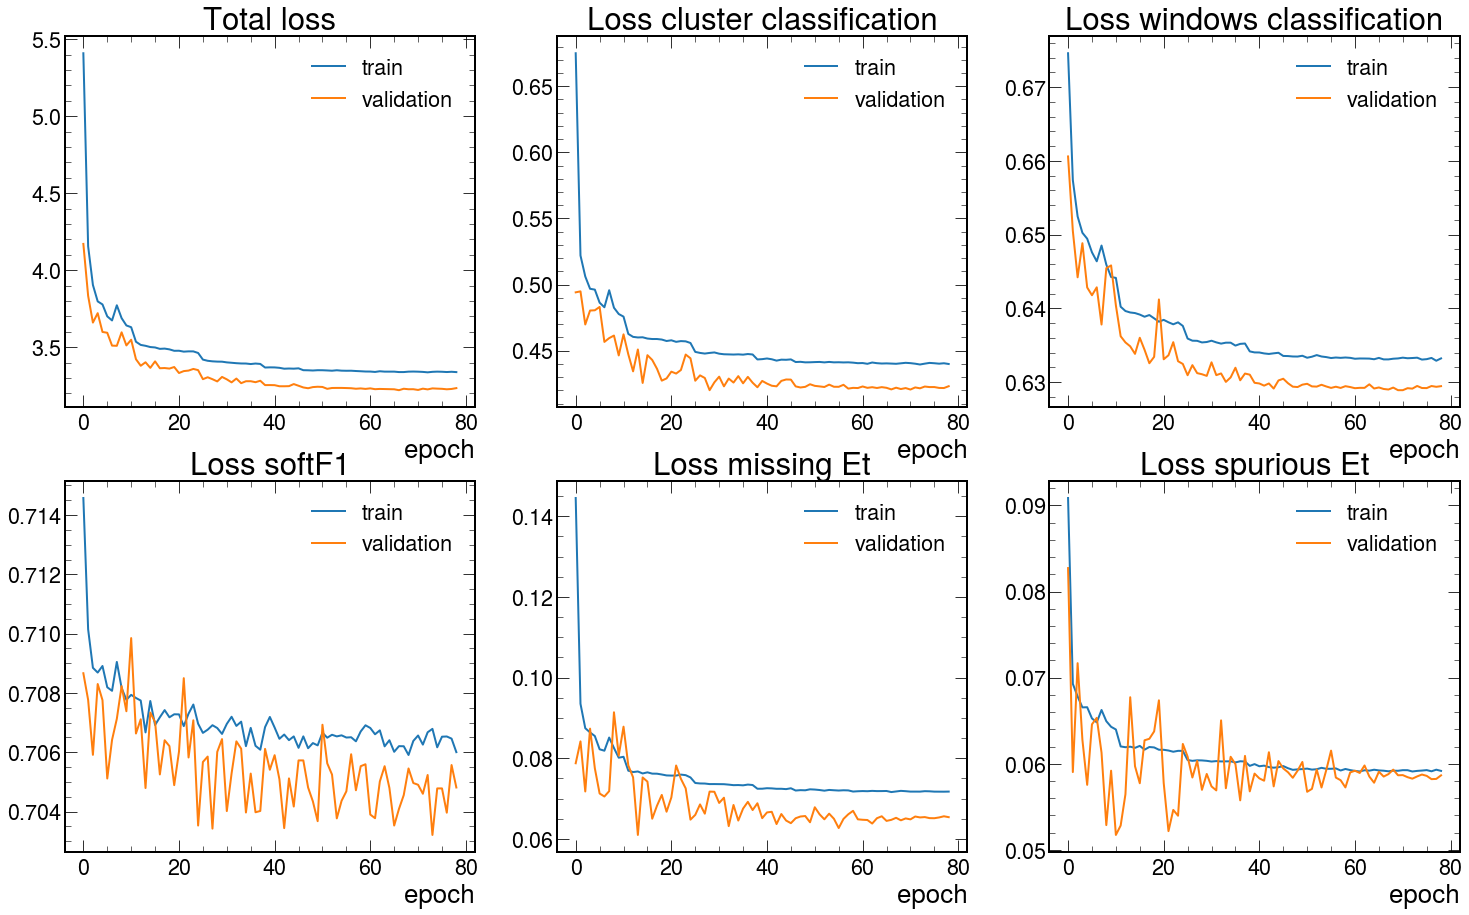

In [59]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 15))

ax1.plot(ret.history["loss"], label="train", linewidth=2)
ax1.plot(ret.history["val_loss"],label="validation", linewidth=2)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.legend()

ax2.plot(ret.history["loss_clusters"], label="train", linewidth=2)
ax2.plot(ret.history["val_loss_clusters"],label="validation", linewidth=2)
ax2.set_title("Loss cluster classification")
ax2.set_xlabel("epoch")
ax2.legend()

ax3.plot(ret.history["loss_windows"], label="train", linewidth=2)
ax3.plot(ret.history["val_loss_windows"],label="validation", linewidth=2)
ax3.set_title("Loss windows classification")
ax3.set_xlabel("epoch")
ax3.legend()

ax4.plot(ret.history["loss_softF1"], label="train", linewidth=2)
ax4.plot(ret.history["val_loss_softF1"],label="validation", linewidth=2)
ax4.set_title("Loss softF1")
ax4.set_xlabel("epoch")
ax4.legend()

ax5.plot(ret.history["loss_et_miss"], label="train", linewidth=2)
ax5.plot(ret.history["val_loss_et_miss"],label="validation", linewidth=2)
ax5.set_title("Loss missing Et")
ax5.set_xlabel("epoch")
ax5.legend()

ax6.plot(ret.history["loss_et_spur"], label="train", linewidth=2)
ax6.plot(ret.history["val_loss_et_spur"],label="validation", linewidth=2)
ax6.set_title("Loss spurious Et")
ax6.set_xlabel("epoch")
ax6.legend()

f.savefig(outdir + "/train_loss.png")


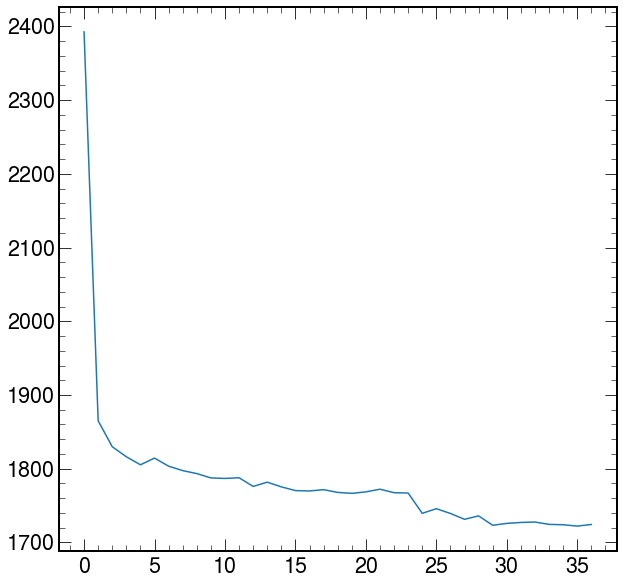

In [101]:
plt.plot(ret.history["loss_en_regr"])
plt.plot(ret.history["loss_en_regr"])

In [20]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
#model.save(outdir+"/model")



In [21]:
conf = [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_et_miss','loss_et_spur','loss_en_regr']

configs = {}
for c in conf:
    if c == 'activation': configs[c] = "elu"
    else: configs[c] = getattr(args, c)
    
import json
json.dump(configs, open(outdir + "/args_load.json","w"), indent=2)

In [100]:
configs

{'models_path': '/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v7/',
 'nepochs': 100,
 'ntrain': 1000000,
 'nval': 200000,
 'lr_decay': 0.0,
 'lr': 0.001,
 'batch_size': 512,
 'opt': 'adam',
 'activation': 'elu',
 'output_dim_rechits': 10,
 'output_dim_nodes': 64,
 'output_dim_gconv': 64,
 'output_dim_sa_clclass': 64,
 'output_dim_sa_windclass': 64,
 'coord_dim': 3,
 'coord_dim_sa': 12,
 'nconv_rechits': 3,
 'nconv': 3,
 'layers_input': [128, 64, 64],
 'layers_clclass': [64, 64, 32],
 'layers_windclass': [64, 64, 32],
 'n_windclasses': 3,
 'dropout': 0.15,
 'l2_reg': True,
 'loss_clusters': 2.0,
 'loss_window': 1.4,
 'loss_softF1': 0.2,
 'loss_et_miss': 7.0,
 'loss_et_spur': 7.0}

### Test loss

In [76]:
X,y_true= tf_data.get(ds_test)

In [77]:
y_pred = model(X)

In [78]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, wind_X, y_metadata, cl_labels = y_true
cl_ens = cl_X[:,:,0]
pred_en =  tf.reduce_sum(cl_ens * tf.squeeze(tf.cast(tf.nn.sigmoid(dense_clclass) > 0.5 , tf.float32)), axis=-1)
corrected_en =  pred_en * tf.squeeze(en_regr_factor)
true_en_gen = y_metadata[:,2]
a = tf.reduce_mean(tf.square(corrected_en - true_en_gen))

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.97505146, 1.1114011 , 1.2477508 , 1.3841004 , 1.5204501 ,
        1.6567998 , 1.7931495 , 1.9294991 , 2.0658488 , 2.2021985 ,
        2.3385482 ], dtype=float32),
 <a list of 512 BarContainer objects>)

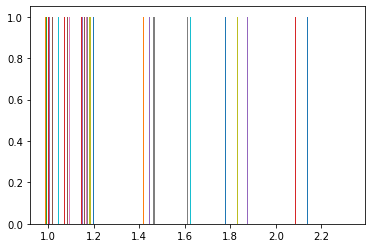

In [83]:
plt.hist(en_regr_factor* 3)

In [117]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)
diff = tf.math.abs(y_target - pred_prob)
Et = cl_X[:,:,1:2]

missing_en = Et * diff * y_target
spurious_en =  Et * diff * (1 - y_target)

reduced_loss_missing = tf.reduce_mean(tf.reduce_sum(missing_en, axis=1)) 
reduced_loss_spurious =  tf.reduce_mean(tf.reduce_sum(spurious_en, axis=1))

In [160]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)

In [169]:
tp = pred_prob * y_target
fn = (1 - pred_prob) * y_target
fp = pred_prob * (1 - y_target)

In [182]:
tptot = tf.reduce_sum(tp, axis=1)
fntot = tf.reduce_sum(fn, axis=1)
fptot = tf.reduce_sum(fp, axis=1)

In [187]:
1 - (2 * tptot)/ (2*tptot + fntot + fptot + 1e-16) 

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.8643937 ],
       [0.8417007 ],
       [0.7678521 ],
       [0.8621445 ],
       [0.8818361 ],
       [0.6749588 ],
       [0.86786455],
       [0.84230775],
       [0.8560391 ],
       [0.84797996],
       [0.8713441 ],
       [0.8565036 ],
       [0.87739176],
       [0.86709696],
       [0.855233  ],
       [0.86079264],
       [0.8512083 ],
       [0.86182773],
       [0.68536377],
       [0.8597818 ],
       [0.86351144],
       [0.863147  ],
       [0.85580873],
       [0.85421795],
       [0.87876534],
       [0.8604276 ],
       [0.86217374],
       [0.8579935 ],
       [0.86134374],
       [0.8482436 ],
       [0.8498958 ],
       [0.8549104 ],
       [0.8570379 ],
       [0.8734256 ],
       [0.8786647 ],
       [0.8799868 ],
       [0.8757078 ],
       [0.8537595 ],
       [0.8767978 ],
       [0.86964816],
       [0.8642583 ],
       [0.85530466],
       [0.86631775],
       [0.5863811 ],
       [0.85295665],
     

In [130]:
reduced_loss_spurious

<tf.Tensor: shape=(), dtype=float32, numpy=0.064462475>

### Layers inspection

In [192]:
model.layers

In [193]:
graphbuild = model.layers[0]

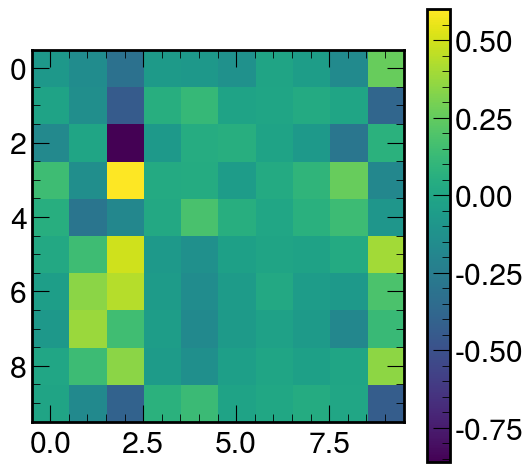

In [194]:
plotM(graphbuild.rechitsGCN.weights[2].numpy())